So a lot of the features have monotonic relations with survival probability. So I decided to try to use this fact.
Another idea was to transform target to have nearly-normal distribution, by first applying min-max transform and then logit transform. Both ideas seem to improve the quality.

# Pip Install Libraries for Metric

In [1]:
!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [2]:
from pathlib import Path
from metric import score
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

ROOT_DATA_PATH = Path(r"/kaggle/input/equity-post-HCT-survival-predictions")

pd.set_option('display.max_columns', 100)

train = pd.read_csv(ROOT_DATA_PATH.joinpath("train.csv"))
test = pd.read_csv(ROOT_DATA_PATH.joinpath("test.csv"))

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',

    # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]

HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]


def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)


def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df


train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()

In [3]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.0.3
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65144
[100]	validation_0-auc:0.72648
[200]	validation_0-auc:0.73447
[300]	validation_0-auc:0.73889
[400]	validation_0-auc:0.74073
[500]	validation_0-auc:0.74241
[596]	validation_0-auc:0.74259
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67116
[100]	validation_0-auc:0.75073
[200]	validation_0-auc:0.75850
[300]	validation_0-auc:0.76222
[400]	validation_0-auc:0.76403
[500]	validation_0-auc:0.76548
[591]	validation_0-auc:0.76577
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67246
[100]	validation_0-auc:0.74840
[200]	validation_0-auc:0.75777
[300]	validation_0-auc:0.76097
[400]	validation_0-auc:0.76271
[500]	validation_0-auc:0.76388
[600]	validation_0-auc:0.76426
[684]	validation_0-auc:0.76414
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.66194
[100]	validatio

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

filterwarnings('ignore')


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long),
        torch.tensor(df.race_group_encoded.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    
    # 创建 LabelEncoder 实例
    race_encoder = LabelEncoder()

    # 对 'race_groups' 列进行标签编码
    train['race_group_encoded'] = race_encoder.fit_transform(train['race_group'])
    test['race_group_encoded'] = race_encoder.fit_transform(test['race_group'])
    train['race_group_encoded'] = train['race_group_encoded'].astype(int)
    test['race_group_encoded'] = test['race_group_encoded'].astype(int)
    return test, train

In [5]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1, 
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs, race_labels = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat, race_labels)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat, race_labels):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)

        # loss, race_loss = self.race_loss_with_penalty(y, y_hat, race_labels, lambda_std=0)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def race_loss_with_penalty(self, y_true, y_pred, race_labels, race_weights=None, lambda_std=0.5):
        # y_true = y_true[:, 0]
        # y_pred = y_pred[:, 0]
        unique_races = torch.unique(race_labels)
        mse_values = []
        total_loss = 0.0
        for race in unique_races:
            indices = (race_labels == race)
            y_true_r = y_true[indices]
            y_pred_r = y_pred[indices]
    
            if len(y_true_r) < 2:  # Skip if not enough samples
                continue
    
            # Compute pairwise differences
            y_true_diff = y_true_r.unsqueeze(0) - y_true_r.unsqueeze(1)
            y_pred_diff = y_pred_r.unsqueeze(0) - y_pred_r.unsqueeze(1)
    
            valid_pairs = (y_true_diff > 0).float()  # Valid pairs where y_i > y_j
            mse_r = torch.sum(valid_pairs * (y_true_diff - y_pred_diff) ** 2) / (torch.sum(valid_pairs) + 1e-8)
    
            # Store MSE for variance calculation
            mse_values.append(mse_r)
    
            # Compute race-weighted loss
            weight = race_weights.get(race.item(), 1.0) if race_weights else 1.0
            total_loss += weight * mse_r
    
        # Compute standard deviation of MSE across races
        if len(mse_values) > 1:
            mse_values = torch.stack(mse_values)
            mse_std = torch.std(mse_values)
        else:
            mse_std = torch.tensor(0.0, device=y_true.device)  # No variance if only one race
    
        # Final loss combines MSE loss and standard deviation loss
        final_loss = total_loss / len(unique_races) + lambda_std * mse_std
        return final_loss, mse_std
    
    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs, race_labels = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat, race_labels)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs, race_labels = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat, race_labels)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

def main(hparams):
    """
    Main function to train the model.
    The steps are as following :
    * load data and fill efs and efs time for test data with 1
    * initialize pred array with 0
    * get categorical and numerical columns
    * split the train data on the stratified criterion : race_group * newborns yes/no
    * preprocess the fold data (create dataloaders)
    * train the model and create final submission output
    """
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    oof_nn_pairwise = np.zeros(len(train_original))
    test_pred = np.zeros(test.shape[0])
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=5, shuffle=True, )
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
        oof_pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        oof_nn_pairwise[test_index] = oof_pred.detach().cpu().numpy()
        # Create submission
        train = tt.iloc[train_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, test)
        pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        test_pred += pred.detach().cpu().numpy()
        
    
    return -test_pred / 5, -oof_nn_pairwise



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()

In [7]:
hparams = None
pairwise_ranking_pred, pairwise_ranking_oof = main(hparams)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN CV =",m)

# Update predictions with classifier mask
pairwise_ranking_oof[oof_xgb == 1] += 0.1
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN with classifier mask -> CV =",m)

pairwise_ranking_pred[pred_efs == 1] += 0.1

Test shape: (3, 59)
Train shape: (28800, 61)


Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6752497553825378     │
│    test_cindex_simple     │    0.6902512907981873     │
│         test_loss         │    0.1836508939046691     │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6737104058265686     │
│    test_cindex_simple     │    0.6838293075561523     │
│         test_loss         │    0.18605950626966658    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6806586980819702     │
│    test_cindex_simple     │    0.6898915767669678     │
│         test_loss         │    0.18443486101155626    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6818004846572876     │
│    test_cindex_simple     │    0.6954762935638428     │
│         test_loss         │    0.18030601723387044    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6749130487442017     │
│    test_cindex_simple     │    0.6818413138389587     │
│         test_loss         │     0.187939253216744     │
└───────────────────────────┴───────────────────────────┘


Pairwise ranking NN CV = 0.6791517654171221

Pairwise ranking NN with classifier mask -> CV = 0.680765089309598


# Pairwise NN done

# CIBMTR Yunbase

In [8]:
!pip install -q --requirement /kaggle/input/yunbase/Yunbase/requirements.txt  \
--no-index --find-links file:/kaggle/input/yunbase/

!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [9]:
source_file_path = '/kaggle/input/yunbase/Yunbase/baseline.py'
target_file_path = '/kaggle/working/baseline.py'
with open(source_file_path, 'r', encoding='utf-8') as file:
    content = file.read()
with open(target_file_path, 'w', encoding='utf-8') as file:
    file.write(content)

In [10]:
from baseline import Yunbase
import pandas as pd#read csv,parquet
import numpy as np#for scientific computation of matrices
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBRegressor,XGBClassifier
from lifelines import KaplanMeierFitter
import warnings#avoid some negligible errors
#The filterwarnings () method is used to set warning filters, which can control the output method and level of warning information.
warnings.filterwarnings('ignore')
import random#provide some function to generate random_seed.
#set random seed,to make sure model can be recurrented.
def seed_everything(seed):
    np.random.seed(seed)#numpy's random seed
    random.seed(seed)#python built-in random seed
seed_everything(seed=2025)

train=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train_solution=train[['ID','efs','efs_time','race_group']].copy()

def logit(p):
    return np.log(p) - np.log(1 - p)
max_efs_time,min_efs_time=80,-100
train['efs_time']=train['efs_time']/(max_efs_time-min_efs_time)
train['efs_time']=train['efs_time'].apply(lambda x:logit(x))
train['efs_time']+=10
print(train['efs_time'].max(),train['efs_time'].min())

race2weight={'American Indian or Alaska Native':0.68,
'Asian':0.7,'Black or African-American':0.67,
'More than one race':0.68,
'Native Hawaiian or other Pacific Islander':0.66,
'White':0.64}
train['weight']=0.5*train['efs']+0.5
train['raceweight']=train['race_group'].apply(lambda x:race2weight.get(x,1))
train['weight']=train['weight']/train['raceweight']
train.drop(['raceweight'],axis=1,inplace=True)

train.head()

11.911759296425227 3.709282073471571


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,weight
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,8.821439,0.735294
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,6.374929,1.428571
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,7.908862,0.735294
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,10.276164,0.781250
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,7.687924,0.735294


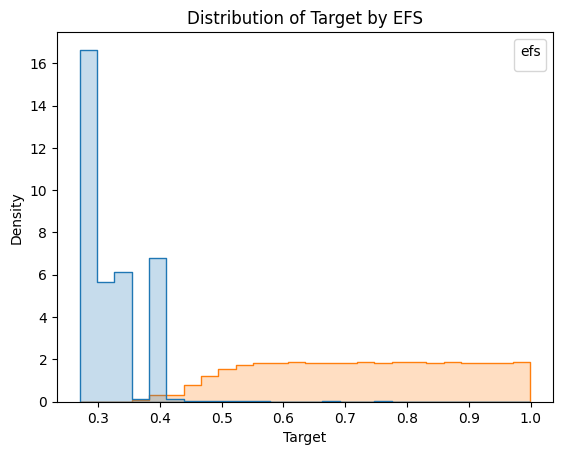

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):

    kmf = KaplanMeierFitter()
    
    kmf.fit(df[time_col], event_observed=df[event_col])
    
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()

    return survival_probabilities

race_group=sorted(train['race_group'].unique())
for race in race_group:
    train.loc[train['race_group']==race,"target"] = transform_survival_probability(train[train['race_group']==race], time_col='efs_time', event_col='efs')
    gap=0.7*(train.loc[(train['race_group']==race)&(train['efs']==0)]['target'].max()-train.loc[(train['race_group']==race)&(train['efs']==1)]['target'].min())/2
    train.loc[(train['race_group']==race)&(train['efs']==0),'target']-=gap

sns.histplot(data=train, x='target', hue='efs', element='step', stat='density', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

train.drop(['efs','efs_time'],axis=1,inplace=True)

Currently supported metrics:['custom_metric', 'mae', 'rmse', 'mse', 'medae', 'rmsle', 'msle', 'mape', 'r2', 'smape', 'auc', 'pr_auc', 'logloss', 'f1_score', 'mcc', 'accuracy', 'multi_logloss']
Currently supported models:['lgb', 'cat', 'xgb', 'ridge', 'Lasso', 'LinearRegression', 'LogisticRegression', 'tabnet', 'Word2Vec', 'tfidfvec', 'countvec']
Currently supported kfolds:['KFold', 'GroupKFold', 'StratifiedKFold', 'StratifiedGroupKFold', 'purged_CV', 'custom_kfold']
Currently supported objectives:['binary', 'multi_class', 'regression']
fit......
load train data
Feature Engineer
< deal with outlier >
< cross feature >
< fillna >
< combine category feature >
< drop useless columns >


0it [00:00, ?it/s]


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column graft_type labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column vent_hist labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column rituximab labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column hla_match_drb1_low labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column prod_type labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column mrd_hct labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column in_vivo_tcd labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

-> for column melphalan_dose labelencoder feature


Pandas Apply:   0%|          | 0/28800 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
< robust scaler >
------------------------------
train.shape:(28800, 96)
feature_count:96
load models
lgb_params:{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 768, 'n_jobs': None, 'num_leaves': 64, 'objective': None, 'random_state': 2025, 'reg_alpha': 0.2, 'reg_lambda': 5, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'mae', 'colsample_bynode': 0.6, 'verbose': -1, 'extra_trees': True, 'max_bin': 255, 'device': 'gpu', 'gpu_use_dp': True}
cat_params:{'iterations': 650, 'learning_rate': 0.1, 'l2_leaf_reg': 1.25, 'loss_function': 'RMSE', 'verbose': 0, 'random_strength': 0.25, 'eval_metric': 'MAE', 'bagging_temperature': 0.5, 'task_type': 'GPU', 'max_depth': 8, 'random_state': 2025, 

  0%|          | 0/10 [00:00<?, ?it/s]

name:lgb,fold:0
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.186498
[500]	valid_0's l1: 0.185242
[750]	valid_0's l1: 0.184182
Did not meet early stopping. Best iteration is:
[767]	valid_0's l1: 0.184029
top10 best features is :['dri_score_transform_donor_age_std', 'dri_score_transform_target_mean', 'conditioning_intensity_transform_target_std', 'conditioning_intensity_transform_donor_age_skew', 'dri_score_transform_target_skew', 'year_hct_transform_target_mean', 'year_hct_transform_target_std', 'comorbidity_score_transform_age_at_hct_skew', 'conditioning_intensity_transform_donor_age_std', 'prim_disease_hct_transform_target_skew']
top10 worst features is :['prod_type_transform_donor_age_count', 'hla_match_a_low_transform_donor_age_count', 'vent_hist_transform_target_count', 'rituximab_transform_donor_age_count', 'hla_match_drb1_low_transform_age_at_hct_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_age_at_hct_count', 'in_

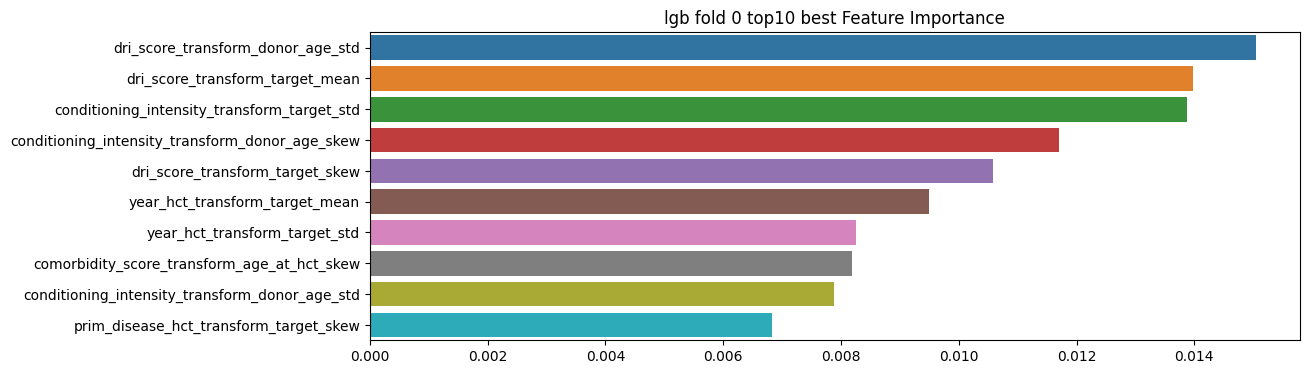

 10%|█         | 1/10 [02:36<23:24, 156.03s/it]

name:lgb,fold:1
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.182558
[500]	valid_0's l1: 0.181361
[750]	valid_0's l1: 0.180814
Did not meet early stopping. Best iteration is:
[768]	valid_0's l1: 0.180701
top10 best features is :['dri_score_transform_target_std', 'prim_disease_hct_transform_age_at_hct_mean', 'year_hct_transform_target_mean', 'dri_score_transform_target_max', 'comorbidity_score-karnofsky_score', 'conditioning_intensity_transform_age_at_hct_skew', 'conditioning_intensity_transform_donor_age_skew', 'comorbidity_score/karnofsky_score', 'cyto_score_detail_transform_target_skew', 'conditioning_intensity_transform_donor_age_mean']
top10 worst features is :['vent_hist_transform_age_at_hct_count', 'vent_hist_transform_target_count', 'hla_match_dqb1_high_transform_target_count', 'prod_type_transform_age_at_hct_count', 'prod_type_transform_target_max', 'in_vivo_tcd_transform_age_at_hct_count', 'in_vivo_tcd_transform_target_count', 'graft_type

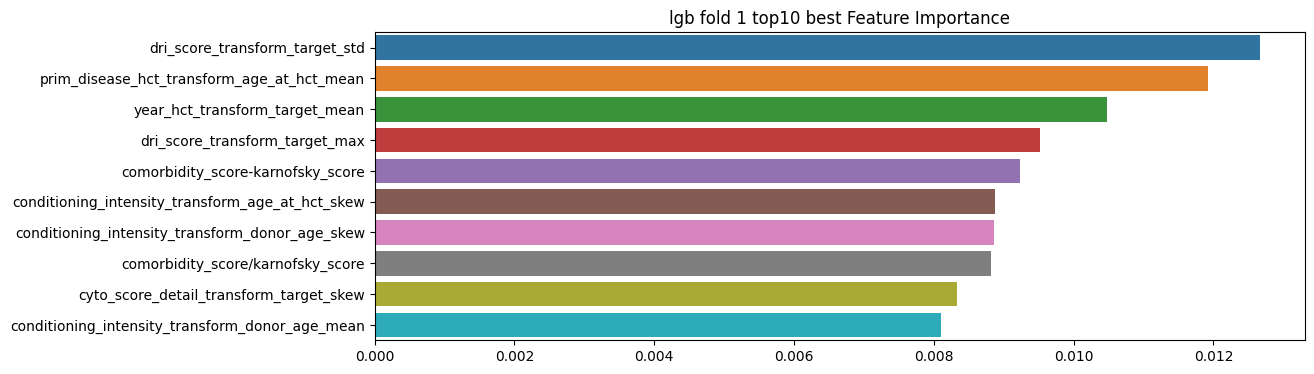

 20%|██        | 2/10 [04:55<19:31, 146.42s/it]

name:lgb,fold:2
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.186144
[500]	valid_0's l1: 0.184564
[750]	valid_0's l1: 0.183478
Did not meet early stopping. Best iteration is:
[762]	valid_0's l1: 0.183385
top10 best features is :['dri_score_transform_donor_age_std', 'prim_disease_hct_transform_donor_age_mean', 'conditioning_intensity_transform_donor_age_skew', 'dri_score_transform_target_max', 'dri_score_transform_target_skew', 'cyto_score_detail_transform_target_std', 'conditioning_intensity_transform_age_at_hct_mean', 'comorbidity_score-karnofsky_score', 'prim_disease_hct_transform_target_skew', 'year_hct_transform_target_std']
top10 worst features is :['vent_histprod_type_transform_donor_age_count', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_age_at_hct_count', 'vent_hist_transform_target_count', 'hla_match_c_low_transform_donor_age_count', 'hla_match_drb1_low_transform_target_count', 'prod_type_transform_age_at_hct_count', 'prod

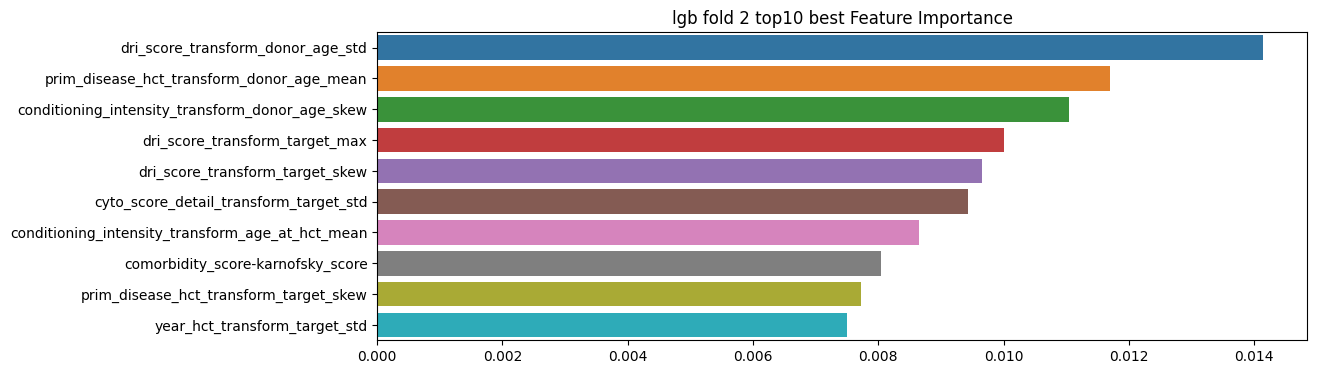

 30%|███       | 3/10 [07:19<16:56, 145.24s/it]

name:lgb,fold:3
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.183731
[500]	valid_0's l1: 0.182522
[750]	valid_0's l1: 0.181823
Did not meet early stopping. Best iteration is:
[761]	valid_0's l1: 0.181703
top10 best features is :['dri_score_transform_donor_age_std', 'dri_score_transform_target_std', 'prim_disease_hct_transform_age_at_hct_skew', 'conditioning_intensity_transform_donor_age_skew', 'cyto_score_detail_transform_target_std', 'conditioning_intensity_transform_donor_age_max', 'cyto_score_detail_transform_target_mean', 'conditioning_intensity_transform_target_max', 'comorbidity_score/karnofsky_score', 'dri_score_transform_target_skew']
top10 worst features is :['graft_type_transform_target_count', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_target_count', 'renal_issue_transform_age_at_hct_count', 'rituximab_transform_target_count', 'hla_match_drb1_low_transform_donor_age_count', 'in_vivo_tcd_transform_age_at_hct_count', 'in_

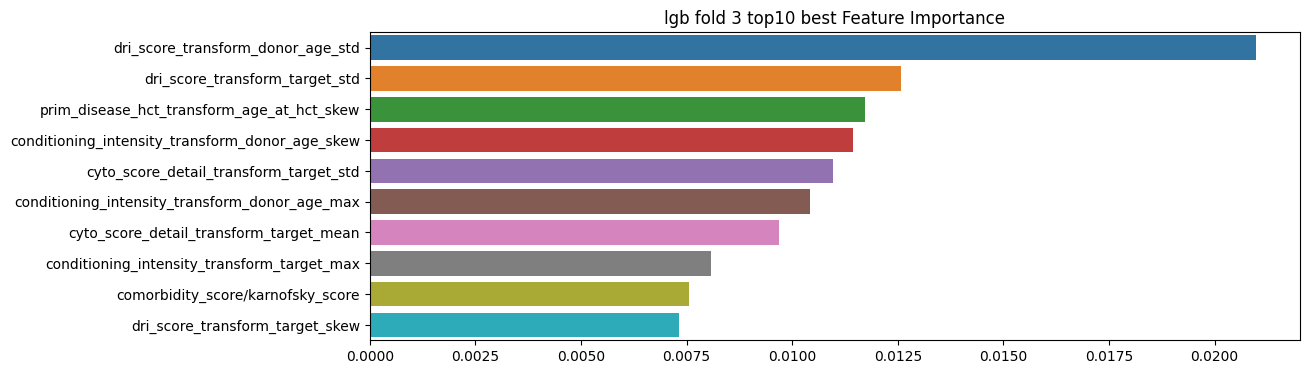

 40%|████      | 4/10 [09:42<14:26, 144.36s/it]

name:lgb,fold:4
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.18647
[500]	valid_0's l1: 0.1854
[750]	valid_0's l1: 0.185164
Did not meet early stopping. Best iteration is:
[761]	valid_0's l1: 0.18505
top10 best features is :['dri_score_transform_donor_age_std', 'prim_disease_hct_transform_donor_age_mean', 'dri_score_transform_target_std', 'conditioning_intensity_transform_age_at_hct_mean', 'year_hct_transform_target_mean', 'comorbidity_score/karnofsky_score', 'prim_disease_hct_transform_age_at_hct_mean', 'dri_score_transform_target_mean', 'donor_age', 'prim_disease_hct_transform_target_mean']
top10 worst features is :['hla_match_dqb1_high_transform_target_count', 'prod_type_transform_age_at_hct_count', 'graft_type_transform_age_at_hct_count', 'prod_type_transform_donor_age_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_age_at_hct_count', 'in_vivo_tcd_transform_target_count', 'melphalan_dose_transform_donor_age_count', 'gra

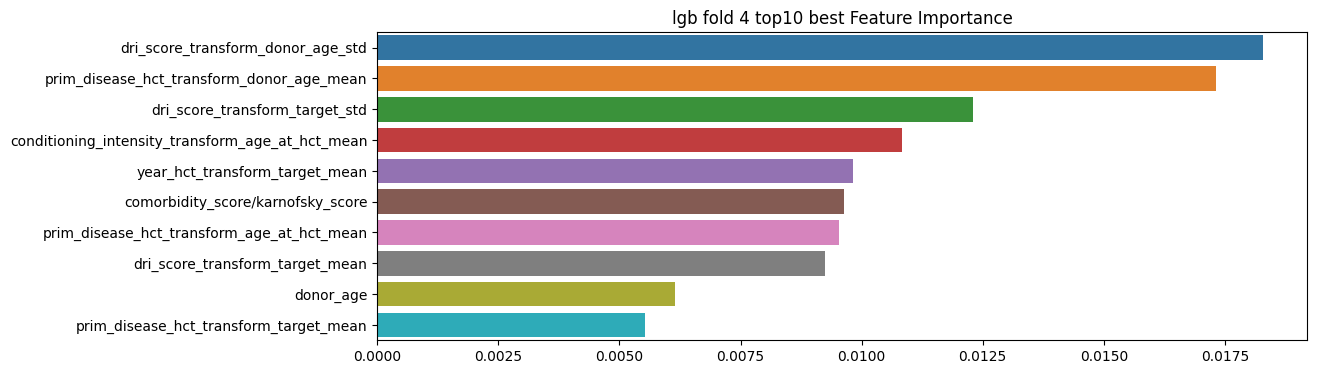

 50%|█████     | 5/10 [12:04<11:57, 143.59s/it]

name:lgb,fold:5
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180245
[500]	valid_0's l1: 0.178609
[750]	valid_0's l1: 0.177713
Did not meet early stopping. Best iteration is:
[762]	valid_0's l1: 0.177673
top10 best features is :['conditioning_intensity_transform_target_mean', 'dri_score_transform_donor_age_std', 'dri_score_transform_target_std', 'conditioning_intensity_transform_age_at_hct_mean', 'dri_score_transform_target_mean', 'conditioning_intensity_transform_donor_age_skew', 'comorbidity_score-karnofsky_score', 'year_hct_transform_target_std', 'year_hct_transform_target_mean', 'dri_score_transform_donor_age_mean']
top10 worst features is :['graft_typevent_hist_transform_donor_age_count', 'melphalan_dose_transform_target_count', 'in_vivo_tcd_transform_age_at_hct_count', 'hla_match_drb1_low_transform_target_count', 'vent_hist', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_target_count', 'in_vivo_tcd_transform_donor_age_count', '

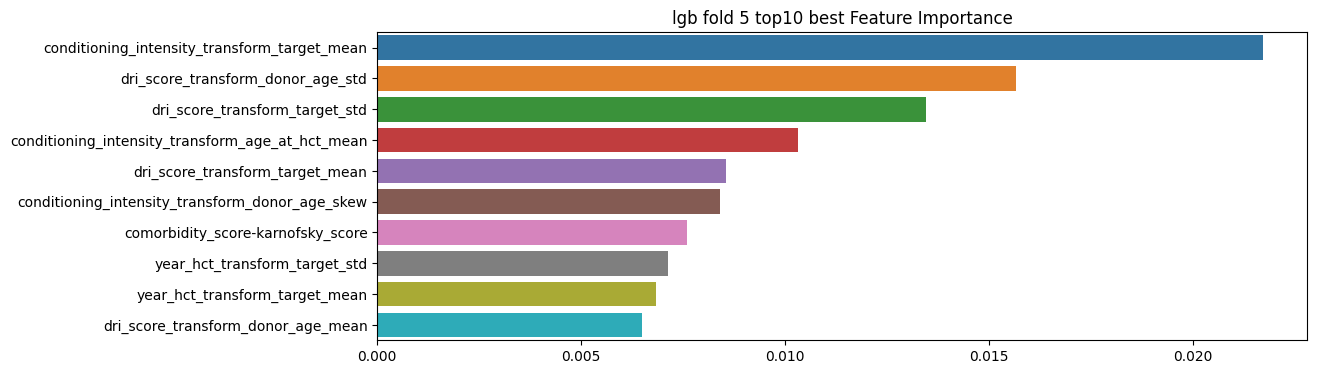

 60%|██████    | 6/10 [14:27<09:32, 143.24s/it]

name:lgb,fold:6
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180909
[500]	valid_0's l1: 0.179653
[750]	valid_0's l1: 0.178773
Did not meet early stopping. Best iteration is:
[739]	valid_0's l1: 0.178699
top10 best features is :['dri_score_transform_target_std', 'prim_disease_hct_transform_target_std', 'dri_score_transform_target_skew', 'conditioning_intensity_transform_age_at_hct_max', 'year_hct_transform_target_mean', 'conditioning_intensity_transform_donor_age_std', 'comorbidity_score-karnofsky_score', 'year_hct_transform_target_std', 'comorbidity_score_transform_donor_age_skew', 'donor_age']
top10 worst features is :['graft_type', 'sex_match_transform_donor_age_count', 'rituximab', 'hla_match_c_low_transform_target_count', 'graft_type_transform_age_at_hct_count', 'vent_hist_transform_donor_age_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_target_count', 'graft_typevent_hist_transform_age_at_hct_count', 'vent_histprod_

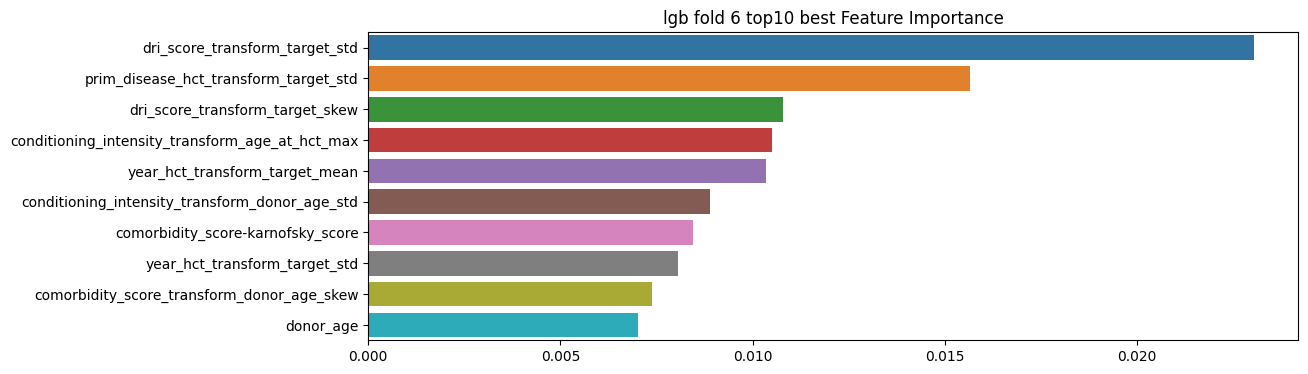

 70%|███████   | 7/10 [16:48<07:07, 142.50s/it]

name:lgb,fold:7
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180841
[500]	valid_0's l1: 0.179743
[750]	valid_0's l1: 0.179172
Did not meet early stopping. Best iteration is:
[768]	valid_0's l1: 0.179132
top10 best features is :['dri_score_transform_donor_age_std', 'prim_disease_hct_transform_age_at_hct_skew', 'conditioning_intensity_transform_target_mean', 'dri_score_transform_target_skew', 'year_hct_transform_target_mean', 'conditioning_intensity_transform_donor_age_max', 'comorbidity_score_transform_target_count', 'conditioning_intensity_transform_target_max', 'comorbidity_score_transform_target_skew', 'comorbidity_score/karnofsky_score']
top10 worst features is :['vent_histrituximab_transform_target_count', 'hla_match_a_low_transform_age_at_hct_count', 'graft_type_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist_transform_donor_age_count', 'hla_match_dqb1_high_transform_age_at_hct_count', 'hla_match_drb1_low_transfo

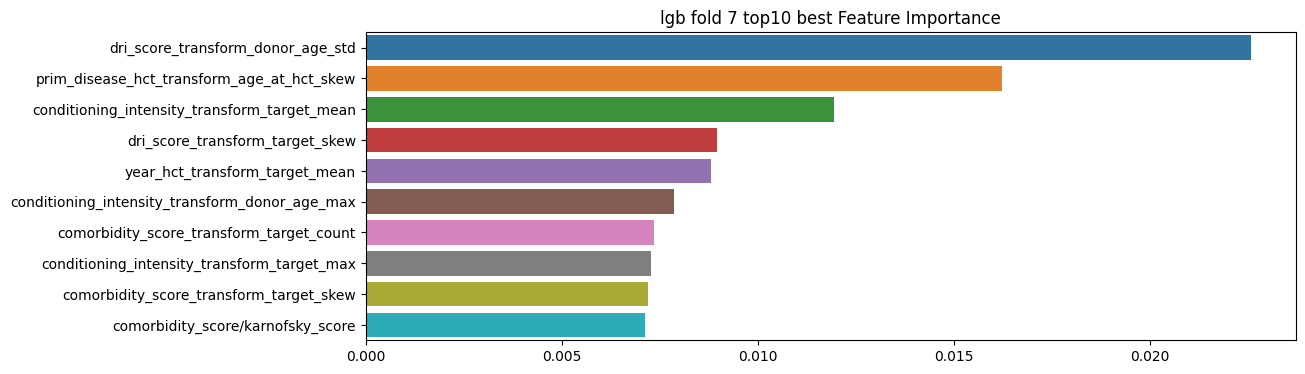

 80%|████████  | 8/10 [19:08<04:43, 141.72s/it]

name:lgb,fold:8
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.183351
[500]	valid_0's l1: 0.182695
[750]	valid_0's l1: 0.182068
Did not meet early stopping. Best iteration is:
[744]	valid_0's l1: 0.181976
top10 best features is :['conditioning_intensity_transform_donor_age_skew', 'conditioning_intensity_transform_target_mean', 'comorbidity_score/karnofsky_score', 'dri_score_transform_donor_age_std', 'year_hct_transform_target_std', 'prim_disease_hct_transform_donor_age_mean', 'dri_score_transform_age_at_hct_std', 'dri_score_transform_age_at_hct_skew', 'conditioning_intensity_transform_target_max', 'dri_score_transform_target_skew']
top10 worst features is :['hla_match_a_low_transform_target_count', 'graft_type_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_target_count', 'hla_match_drb1_low_transform_age_at_hct_count', 'in_vivo_tcd_transform_age_at_hct_count', 'melphalan

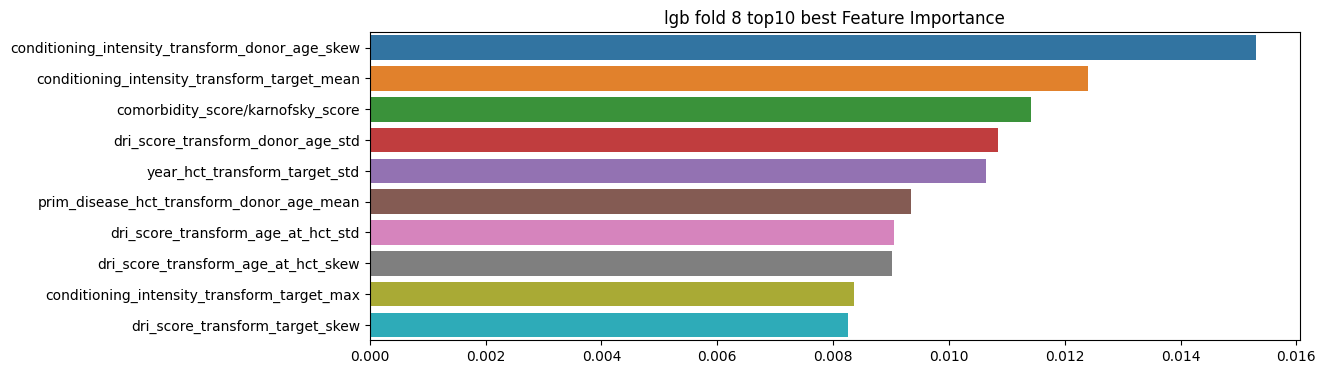

 90%|█████████ | 9/10 [21:28<02:21, 141.07s/it]

name:lgb,fold:9
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.185141
[500]	valid_0's l1: 0.184162
[750]	valid_0's l1: 0.183295
Did not meet early stopping. Best iteration is:
[748]	valid_0's l1: 0.183269
top10 best features is :['dri_score_transform_donor_age_std', 'prim_disease_hct_transform_age_at_hct_skew', 'conditioning_intensity_transform_donor_age_skew', 'conditioning_intensity_transform_target_skew', 'comorbidity_score/karnofsky_score', 'year_hct_transform_target_mean', 'year_hct_transform_target_std', 'dri_score_transform_target_max', 'dri_score_transform_target_std', 'comorbidity_score-karnofsky_score']
top10 worst features is :['hla_match_drb1_low_transform_age_at_hct_count', 'in_vivo_tcd_transform_target_count', 'graft_type_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist_transform_donor_age_count', 'prod_type_transform_target_count', 'in_vivo_tcd_transform_age_at_hct_count', 'hla_match_a_low_transform_target

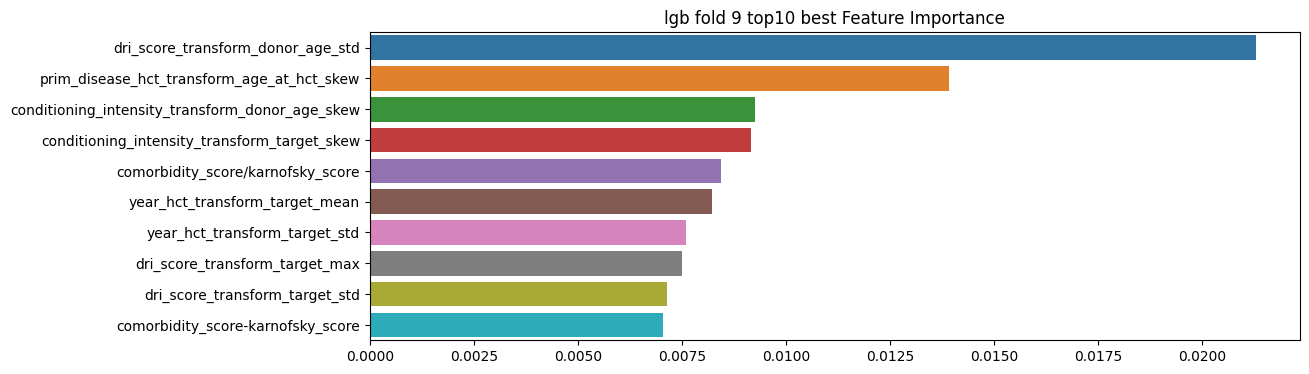

100%|██████████| 10/10 [23:50<00:00, 143.09s/it]


mae------------------------------>0.1815615729119001


  0%|          | 0/10 [00:00<?, ?it/s]

name:cat,fold:0


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2005724	test: 0.2186184	best: 0.2186184 (0)	total: 344ms	remaining: 3m 43s
250:	learn: 0.1330404	test: 0.1850203	best: 0.1850077 (249)	total: 5.92s	remaining: 9.41s
500:	learn: 0.1065245	test: 0.1833075	best: 0.1832097 (478)	total: 11.4s	remaining: 3.4s
649:	learn: 0.0948724	test: 0.1827349	best: 0.1826509 (628)	total: 14.7s	remaining: 0us
bestTest = 0.182650884
bestIteration = 628
Shrink model to first 629 iterations.
top10 best features is :['donor_age', 'comorbidity_score/karnofsky_score', 'age_at_hct', 'dri_score_transform_target_std', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age-age_at_hct', 'donor_age*age_at_hct']
top10 worst features is :['prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_age_at_hct_skew', 'mrd_hctin_vivo_tcd_transform_age_at_hct_max', 'mrd_hctin_vivo_tcd_transform_target_count', 'mrd_hctmelphalan_dose_transform_target_co

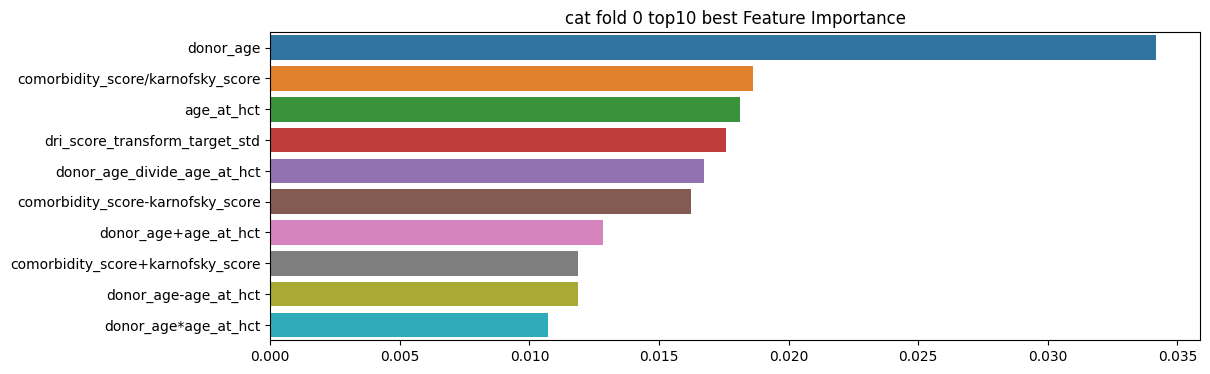

 10%|█         | 1/10 [01:17<11:39, 77.76s/it]

name:cat,fold:1


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2004687	test: 0.2195077	best: 0.2195077 (0)	total: 37.3ms	remaining: 24.2s
250:	learn: 0.1335459	test: 0.1834172	best: 0.1834172 (250)	total: 5.64s	remaining: 8.97s
500:	learn: 0.1072815	test: 0.1803083	best: 0.1803073 (498)	total: 11.2s	remaining: 3.32s
649:	learn: 0.0953858	test: 0.1794442	best: 0.1793584 (629)	total: 14.5s	remaining: 0us
bestTest = 0.1793584188
bestIteration = 629
Shrink model to first 630 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'donor_age_divide_age_at_hct', 'donor_age-age_at_hct', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age+age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_mean', 'prod_typemelphalan_dose_transform_donor_age_max', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform

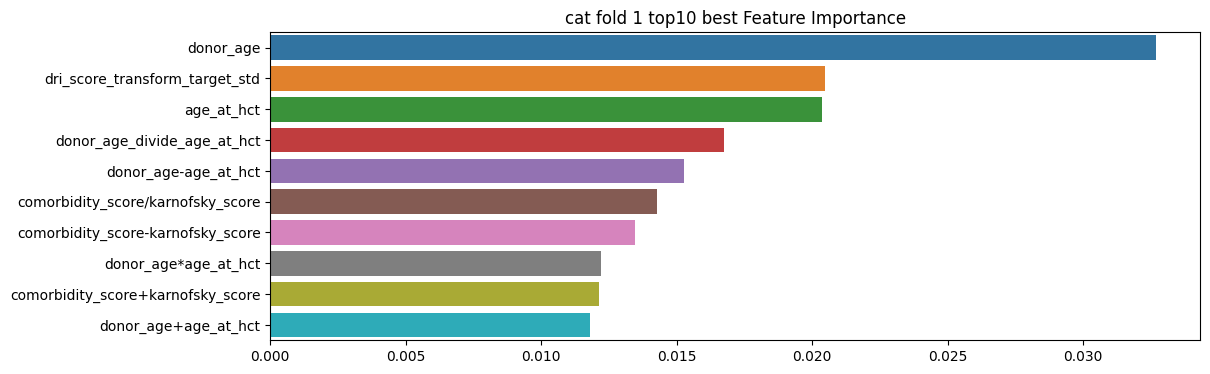

 20%|██        | 2/10 [02:33<10:10, 76.35s/it]

name:cat,fold:2


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2002554	test: 0.2213291	best: 0.2213291 (0)	total: 37.1ms	remaining: 24.1s
250:	learn: 0.1328781	test: 0.1859146	best: 0.1859146 (250)	total: 5.71s	remaining: 9.09s
500:	learn: 0.1068485	test: 0.1835345	best: 0.1833824 (470)	total: 11.4s	remaining: 3.39s
649:	learn: 0.0947793	test: 0.1825659	best: 0.1825659 (649)	total: 14.8s	remaining: 0us
bestTest = 0.1825659434
bestIteration = 649
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'donor_age-age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'year_hct_transform_target_std', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typein_vivo_tcd_transform_donor_age_std', 'prod_typein_vivo_tcd_transform_age_at_hct_count', 'prod_typein_vivo_tcd_transform_age_at_hct_std', 'prod_typein_vivo_tcd_transform_target_count', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan

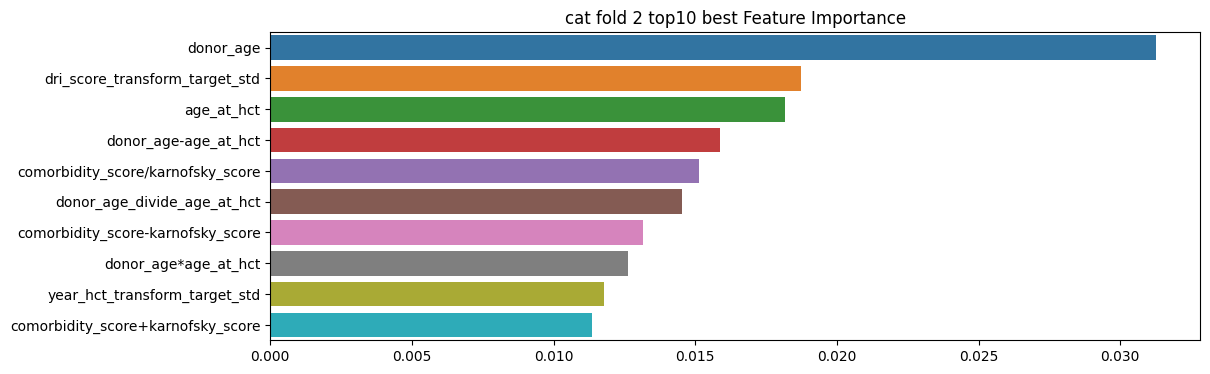

 30%|███       | 3/10 [03:48<08:52, 76.13s/it]

name:cat,fold:3


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2005763	test: 0.2187900	best: 0.2187900 (0)	total: 36.7ms	remaining: 23.8s
250:	learn: 0.1331966	test: 0.1834904	best: 0.1834820 (248)	total: 5.74s	remaining: 9.13s
500:	learn: 0.1065973	test: 0.1806144	best: 0.1806144 (500)	total: 11.3s	remaining: 3.36s
649:	learn: 0.0947648	test: 0.1795315	best: 0.1795267 (648)	total: 14.6s	remaining: 0us
bestTest = 0.1795266893
bestIteration = 648
Shrink model to first 649 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_std', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_skew', 'prod_typemelphalan_dose_transform_target_count', 'prod_typemelphalan_dose_tran

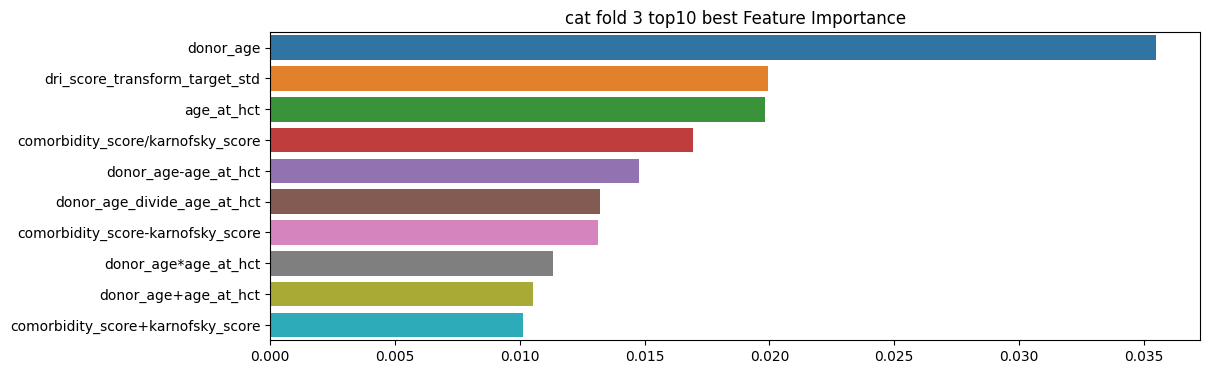

 40%|████      | 4/10 [05:04<07:35, 75.93s/it]

name:cat,fold:4


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2000468	test: 0.2228436	best: 0.2228436 (0)	total: 37.7ms	remaining: 24.5s
250:	learn: 0.1335661	test: 0.1864523	best: 0.1864250 (247)	total: 5.6s	remaining: 8.9s
500:	learn: 0.1076705	test: 0.1844108	best: 0.1844108 (500)	total: 11.2s	remaining: 3.33s
649:	learn: 0.0956822	test: 0.1832321	best: 0.1832321 (649)	total: 14.7s	remaining: 0us
bestTest = 0.1832320743
bestIteration = 649
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age_divide_age_at_hct', 'donor_age-age_at_hct', 'donor_age+age_at_hct', 'donor_age*age_at_hct', 'year_hct_transform_target_std']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_count', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_mean', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dos

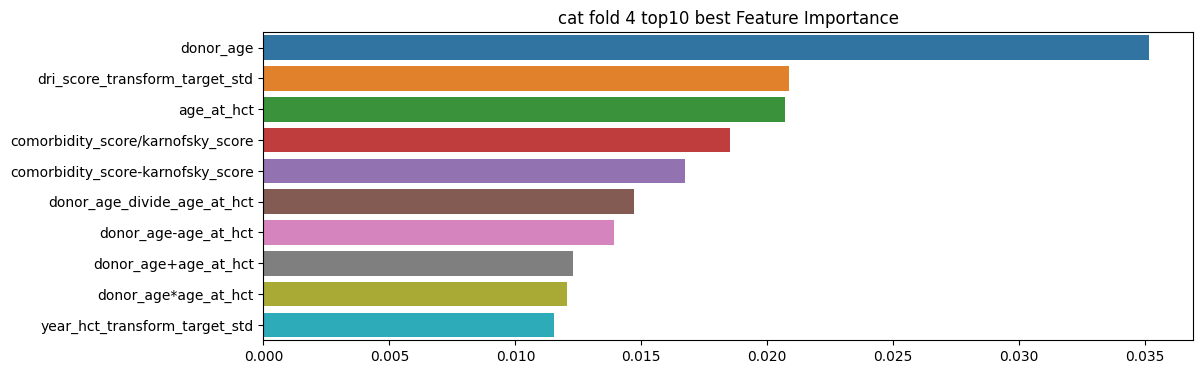

 50%|█████     | 5/10 [06:20<06:19, 76.00s/it]

name:cat,fold:5


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2010388	test: 0.2169667	best: 0.2169667 (0)	total: 82.7ms	remaining: 53.7s
250:	learn: 0.1335247	test: 0.1810832	best: 0.1810604 (249)	total: 5.93s	remaining: 9.44s
500:	learn: 0.1069905	test: 0.1790729	best: 0.1789815 (461)	total: 11.5s	remaining: 3.41s
649:	learn: 0.0949822	test: 0.1783691	best: 0.1783691 (649)	total: 14.8s	remaining: 0us
bestTest = 0.1783691406
bestIteration = 649
top10 best features is :['donor_age', 'age_at_hct', 'donor_age_divide_age_at_hct', 'dri_score_transform_target_std', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'donor_age-age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_mean', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_age_at_hct_skew', 'prod_typemelphalan_dose_transform_target_skew', 'mrd_hctin_vivo_tcd_tra

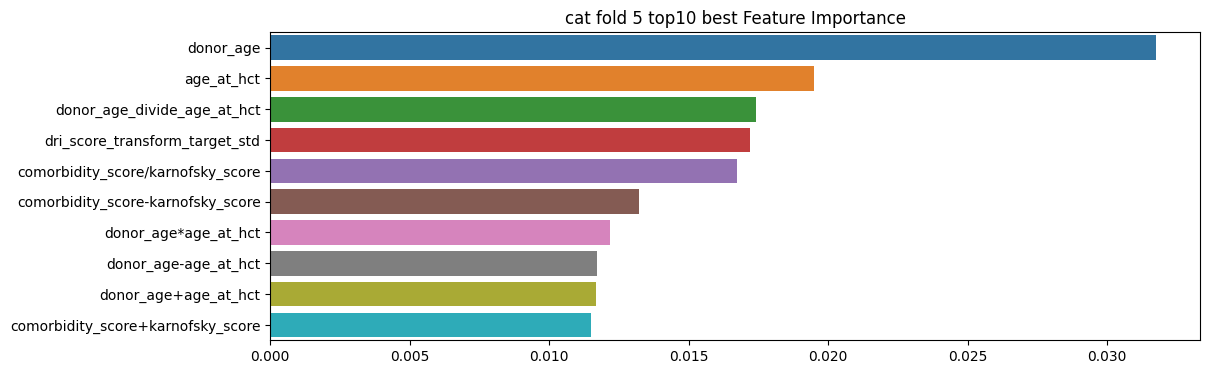

 60%|██████    | 6/10 [07:36<05:03, 75.88s/it]

name:cat,fold:6


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2002267	test: 0.2215818	best: 0.2215818 (0)	total: 36.6ms	remaining: 23.8s
250:	learn: 0.1328280	test: 0.1824777	best: 0.1824579 (247)	total: 5.69s	remaining: 9.05s
500:	learn: 0.1068553	test: 0.1792737	best: 0.1792737 (500)	total: 11.3s	remaining: 3.35s
649:	learn: 0.0946667	test: 0.1787056	best: 0.1786997 (639)	total: 14.6s	remaining: 0us
bestTest = 0.178699663
bestIteration = 639
Shrink model to first 640 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'comorbidity_score/karnofsky_score', 'donor_age+age_at_hct', 'donor_age-age_at_hct', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typein_vivo_tcd_transform_age_at_hct_skew', 'prod_typein_vivo_tcd_transform_target_count', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_mean', 'prod_typemelphalan_dose_transform

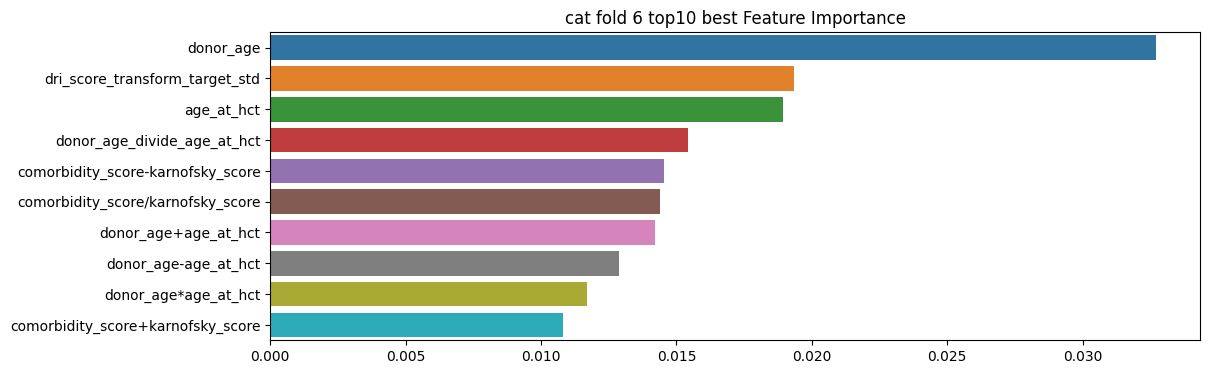

 70%|███████   | 7/10 [08:52<03:47, 75.89s/it]

name:cat,fold:7


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2006985	test: 0.2191510	best: 0.2191510 (0)	total: 36ms	remaining: 23.4s
250:	learn: 0.1328676	test: 0.1823549	best: 0.1823475 (247)	total: 5.68s	remaining: 9.03s
500:	learn: 0.1067300	test: 0.1807274	best: 0.1807204 (496)	total: 11.7s	remaining: 3.48s
649:	learn: 0.0948916	test: 0.1799085	best: 0.1799085 (649)	total: 15s	remaining: 0us
bestTest = 0.1799084981
bestIteration = 649
top10 best features is :['donor_age', 'age_at_hct', 'dri_score_transform_target_std', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'donor_age+age_at_hct', 'dri_score_transform_donor_age_std', 'donor_age*age_at_hct']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_count', 'prod_typemelphalan_dose_transform_donor_age_mean', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelpha

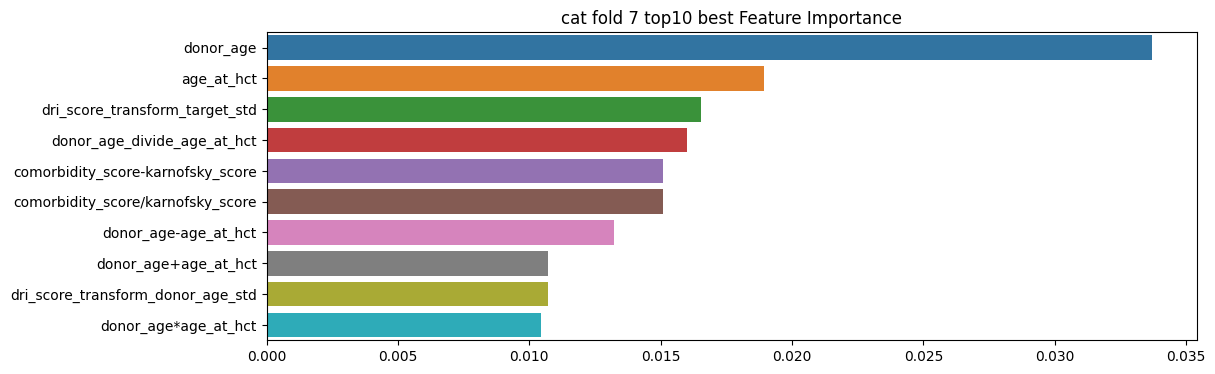

 80%|████████  | 8/10 [10:07<02:31, 75.70s/it]

name:cat,fold:8


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2004649	test: 0.2186805	best: 0.2186805 (0)	total: 38.4ms	remaining: 24.9s
250:	learn: 0.1333673	test: 0.1828066	best: 0.1827827 (249)	total: 5.69s	remaining: 9.04s
500:	learn: 0.1067746	test: 0.1805568	best: 0.1805568 (500)	total: 11.2s	remaining: 3.33s
649:	learn: 0.0945755	test: 0.1801819	best: 0.1800699 (636)	total: 14.5s	remaining: 0us
bestTest = 0.1800698598
bestIteration = 636
Shrink model to first 637 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'comorbidity_score-karnofsky_score', 'dri_score_transform_target_std', 'donor_age-age_at_hct', 'donor_age_divide_age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age*age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typein_vivo_tcd_transform_age_at_hct_count', 'prod_typein_vivo_tcd_transform_age_at_hct_mean', 'prod_typein_vivo_tcd_transform_target_mean', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_age

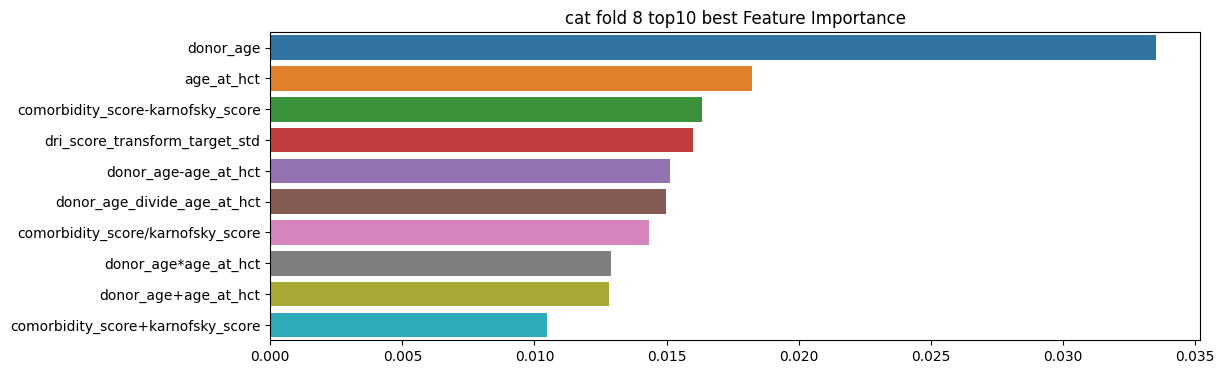

 90%|█████████ | 9/10 [11:22<01:15, 75.47s/it]

name:cat,fold:9


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.1999389	test: 0.2236215	best: 0.2236215 (0)	total: 38.2ms	remaining: 24.8s
250:	learn: 0.1332464	test: 0.1854357	best: 0.1854357 (250)	total: 5.71s	remaining: 9.07s
500:	learn: 0.1066640	test: 0.1829758	best: 0.1829387 (495)	total: 11.3s	remaining: 3.37s
649:	learn: 0.0945985	test: 0.1820043	best: 0.1820043 (649)	total: 14.7s	remaining: 0us
bestTest = 0.182004314
bestIteration = 649
top10 best features is :['donor_age', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age-age_at_hct', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age_divide_age_at_hct', 'dri_score_transform_target_std', 'donor_age+age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_mean', 'prod_typein_vivo_tcd_transform_target_max', 'prod_typemelphalan_dose_transform_donor_age_std', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_tra

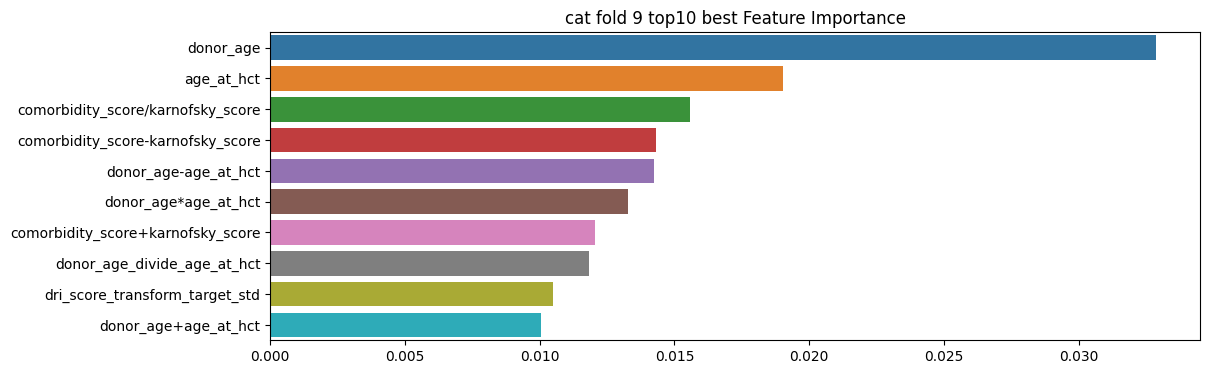

100%|██████████| 10/10 [12:38<00:00, 75.83s/it]

mae------------------------------>0.18063854647344907


In [12]:
#nunique=2
nunique2=[col for col in train.columns if train[col].nunique()==2 and col!='efs']
#nunique<50
nunique50=[col for col in train.columns if train[col].nunique()<50 and col not in ['efs','weight']]+['age_group','dri_score_NA']

def FE(df):
    print("< deal with outlier >")
    df['nan_value_each_row'] = df.isnull().sum(axis=1)
    #year_hct=2020 only 4 rows.
    df['year_hct']=df['year_hct'].replace(2020,2019)
    df['age_group']=df['age_at_hct']//10
    #karnofsky_score 40 only 10 rows.
    df['karnofsky_score']=df['karnofsky_score'].replace(40,50)
    #hla_high_res_8=2 only 2 rows.
    df['hla_high_res_8']=df['hla_high_res_8'].replace(2,3)
    #hla_high_res_6=0 only 1 row.
    df['hla_high_res_6']=df['hla_high_res_6'].replace(0,2)
    #hla_high_res_10=3 only 1 row.
    df['hla_high_res_10']=df['hla_high_res_10'].replace(3,4)
    #hla_low_res_8=2 only 1 row.
    df['hla_low_res_8']=df['hla_low_res_8'].replace(2,3)
    df['dri_score']=df['dri_score'].replace('Missing disease status','N/A - disease not classifiable')
    df['dri_score_NA']=df['dri_score'].apply(lambda x:int('N/A' in str(x)))
    for col in ['diabetes','pulm_moderate','cardiac']:
        df.loc[df[col].isna(),col]='Not done'

    print("< cross feature >")
    df['donor_age-age_at_hct']=df['donor_age']-df['age_at_hct']
    df['comorbidity_score+karnofsky_score']=df['comorbidity_score']+df['karnofsky_score']
    df['comorbidity_score-karnofsky_score']=df['comorbidity_score']-df['karnofsky_score']
    df['comorbidity_score*karnofsky_score']=df['comorbidity_score']*df['karnofsky_score']
    df['comorbidity_score/karnofsky_score']=df['comorbidity_score']/df['karnofsky_score']
    
    print("< fillna >")
    df[nunique50]=df[nunique50].astype(str).fillna('NaN')
    
    print("< combine category feature >")
    for i in range(len(nunique2)):
        for j in range(i+1,len(nunique2)):
            df[nunique2[i]+nunique2[j]]=df[nunique2[i]].astype(str)+df[nunique2[j]].astype(str)
    
    print("< drop useless columns >")
    df.drop(['ID'],axis=1,inplace=True,errors='ignore')
    return df

combine_category_cols=[]
for i in range(len(nunique2)):
    for j in range(i+1,len(nunique2)):
        combine_category_cols.append(nunique2[i]+nunique2[j])  

total_category_feature=nunique50+combine_category_cols

target_stat=[]
for j in range(len(total_category_feature)):
   for col in ['donor_age','age_at_hct','target']:
    target_stat.append( (total_category_feature[j],col,['count','mean','max','std','skew']) )

num_folds=10

lgb_params={"boosting_type": "gbdt","metric": 'mae',
            'random_state': 2025,  "max_depth": 9,"learning_rate": 0.1,
            "n_estimators": 768,"colsample_bytree": 0.6,"colsample_bynode": 0.6,
            "verbose": -1,"reg_alpha": 0.2,
            "reg_lambda": 5,"extra_trees":True,'num_leaves':64,"max_bin":255,
            'importance_type': 'gain',#better than 'split'
            'device':'gpu','gpu_use_dp':True
           }

cat_params={'random_state':2025,'eval_metric' : 'MAE',
            'bagging_temperature': 0.50,'iterations': 650,
            'learning_rate': 0.1,'max_depth': 8,
            'l2_leaf_reg': 1.25,'min_data_in_leaf': 24,
            'random_strength' : 0.25, 'verbose': 0,
            'task_type':'GPU',
            }
xgb_params={'random_state': 2025, 'n_estimators': 256, 
            'learning_rate': 0.1, 'max_depth': 6,
            'reg_alpha': 0.08, 'reg_lambda': 0.8, 
            'subsample': 0.95, 'colsample_bytree': 0.6, 
            'min_child_weight': 3,'early_stopping_rounds':1024,
             'enable_categorical':True,'tree_method':'gpu_hist'
            }

yunbase=Yunbase(num_folds=num_folds,
                  models=[(LGBMRegressor(**lgb_params),'lgb'),
                          (CatBoostRegressor(**cat_params),'cat')
                         ],
                  FE=FE,
                  seed=2025,
                  objective='regression',
                  metric='mae',
                  target_col='target',
                  device='gpu',
                  one_hot_max=-1,
                  early_stop=1000,
                  cross_cols=['donor_age','age_at_hct'],
                  target_stat=target_stat,
                  use_data_augmentation=True,
                  use_scaler=True,
                  log=250,
                  plot_feature_importance=True,
                  #print metric score when model training
                  use_eval_metric=False,
)
yunbase.fit(train,category_cols=nunique2)

In [13]:
import pandas.api.types
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

weights = [0.4,0.4]

yun_lgb_prediction=np.load(f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
lgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':yun_lgb_prediction})
print(f"lgb_score:{score(train_solution.copy(),lgb_prediction.copy(),row_id_column_name='ID')}")
#xgb_prediction=np.load(f"Yunbase_info/xgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
#xgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':xgb_prediction})
#print(f"xgb_score:{score(train_solution.copy(),xgb_prediction.copy(),row_id_column_name='ID')}")
yun_cat_prediction=np.load(f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
cat_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':yun_cat_prediction})
print(f"cat_score:{score(train_solution.copy(),cat_prediction.copy(),row_id_column_name='ID')}")

y_preds=[lgb_prediction.copy(),cat_prediction.copy()]
final_prediction=lgb_prediction.copy()
final_prediction['prediction']=0
for i in range(len(y_preds)):
    final_prediction['prediction']+=weights[i]*y_preds[i]['prediction']
metric=score(train_solution.copy(),final_prediction.copy(),row_id_column_name='ID')
print(f"final_CV:{metric}")

lgb_score:0.6730360430401596
cat_score:0.670298914179167
final_CV:0.6764801578849649


In [14]:
yun_preds=yunbase.predict(test,weights=weights)
yunbase.target_col='prediction'
yunbase.submit("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv",yun_preds,
               save_name='submission1'
              )

predict......
weight normalization
weights:[1. 1.]
final_repeat0_mae:0.18022219200356535
load test data
Feature Engineer
< deal with outlier >
< cross feature >
< fillna >
< combine category feature >
< drop useless columns >


0it [00:00, ?it/s]


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column graft_type labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column vent_hist labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column rituximab labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column hla_match_drb1_low labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column prod_type labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column mrd_hct labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column in_vivo_tcd labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

-> for column melphalan_dose labelencoder feature


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
< robust scaler >
------------------------------
test.shape:(3, 96)
prediction on test data
submission......


# Yunbase done, my xgb

In [15]:
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

## Evaluation metric

In [16]:
import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score_f(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))


## Load the data

In [17]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

## Feature Engineering

In [18]:
# seperate the sex_match feature
def add_features(df):
    sex_match = df.sex_match.astype(str)
    sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    df['sex_match_bool'] = sex_match.astype("object")
    return df

In [19]:
def enhance_features(df):
    """Create more sophisticated features from the raw data"""
    df_new = df.copy()
    
    # 1. Create composite HLA match score
    df_new['hla_match_total'] = df_new[[col for col in df.columns if 'hla_match' in col]].sum(axis=1, skipna=True)
    
    # 2. HLA compatibility ratio
    cols_hla_high = [col for col in df.columns if 'hla_high' in col]
    df_new['hla_high_available'] = df_new[cols_hla_high].notna().sum(axis=1)
    df_new['hla_high_ratio'] = df_new[cols_hla_high].sum(axis=1, skipna=True) / df_new['hla_high_available']
    
    # 3. Age-based risk groups
    df_new['age_group'] = pd.cut(df_new['age_at_hct'], 
                                 bins=[0, 18, 40, 60, 100], 
                                 labels=['pediatric', 'young_adult', 'adult', 'senior'])
    
    # 4. Disease and conditioning interaction
    df_new['disease_conditioning'] = df_new['prim_disease_hct'] + "_" + df_new['conditioning_intensity'].fillna('unknown')
    
    # 5. TBI and conditioning interaction
    df_new['tbi_intensity'] = df_new['tbi_status'].fillna('No TBI') + "_" + df_new['conditioning_intensity'].fillna('unknown')
    
    # # 6. Comorbidity count
    # comorbidity_cols = ['diabetes', 'pulm_severe', 'pulm_moderate', 'prior_tumor', 'psych_disturb', 
    #                     'arrhythmia', 'hepatic_mild', 'hepatic_severe', 'renal_issue']
    # df_new['comorbidity_count'] = df_new[comorbidity_cols].notna().sum(axis=1)
    
    # # 7. Risk markers count
    # risk_markers = ['obesity', 'diabetes', 'hepatic_mild', 'hepatic_severe', 'pulm_moderate', 'pulm_severe']
    # df_new['risk_marker_count'] = df_new[risk_markers].notna().sum(axis=1)
    
    return df_new

In [20]:
test = add_features(test)
train = add_features(train)

test_cp = enhance_features(test)
train_cp = enhance_features(train)

## Generate target

In [21]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    
    # Keep events within critical period and all censored observations
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    
    kmf.fit(df_[time_col], df_[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

def transform_nelson(df, time_col='efs_time', event_col='efs'):
    naf = NelsonAalenFitter()
    # Keep events within critical period and all censored observations
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    
    naf.fit(df_[time_col], df_[event_col])
    y = -naf.cumulative_hazard_at_times(df[time_col]).values
    return y

In [22]:
def transform_decay(df, time_col='efs_time', event_col='efs'):
    """Create a more sophisticated survival target combining event status and timing"""
    
    # Define weights for different time periods
    early_weight = 1.0      # Early events (≤1 year)
    late_weight = 0.7       # Later events
    censor_weight = 0.5     # Weight for censored observations
    
    # Create base risk score
    df['time_component'] = np.exp(-df[time_col] / 24)  # Time-based decay
    
    # Apply different weights based on event status and timing
    early_mask = (df[time_col] <= 12) & (df[event_col] == 1)
    late_mask = (df[time_col] > 12) & (df[event_col] == 1)
    censor_mask = df[event_col] == 0
    
    # Combine components
    risk = np.zeros(len(df))
    risk[early_mask] = early_weight * (df['time_component'] + 0.5)[early_mask]
    risk[late_mask] = late_weight * df['time_component'][late_mask]
    risk[censor_mask] = censor_weight * df['time_component'][censor_mask] * np.exp(-df[time_col][censor_mask] / 36)
    
    # Scale to reasonable range (1-10)
    risk = 1 + 9 * (risk - risk.min()) / (risk.max() - risk.min())
    
    return risk

In [23]:
train["y1"] = transform_nelson(train, time_col='efs_time', event_col='efs')
train["y2"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

train_cp["y1"] = transform_nelson(train_cp, time_col='efs_time', event_col='efs')
train_cp["y2"] = transform_survival_probability(train_cp, time_col='efs_time', event_col='efs')
# train["y3"] = transform_decay(train, time_col='efs_time', event_col='efs')

In [24]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,sex_match_bool,y1,y2
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,False,-0.776731,0.459898
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,True,-0.165468,0.847495
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,False,-0.773285,0.461485
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,True,-0.776731,0.459898
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,False,-0.768413,0.463739


## Model training pipeline

In [25]:
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

def time_decay_weight(efs_time, efs):
    min_weight = 0.65
    max_weight = 1.0
    
    def smooth_decay(t, is_event):
        if is_event:
            return np.where(
                t > 40,
                max_weight * np.exp(-0.005 * (t - 40)),
                max_weight
            )
        else:
            # 未事件样本使用连续的tanh混合
            # 主要下降曲线 - 在80个月时达到0.65
            main_decay = max_weight - 0.35 * np.tanh(t/25)
            
            # 加速下降到目标值
            extra_decay = 0.15 * np.tanh((t - 40)/12)
            
            # 确保80个月后保持在0.65
            final_adjust = np.where(t > 80, min_weight, main_decay - extra_decay)
            # 限制在[min_weight, max_weight]范围内
            return np.clip(final_adjust, min_weight, max_weight)
    
    # 应用衰减
    weights = np.where(
        efs == 0,
        smooth_decay(efs_time, False),
        smooth_decay(efs_time, True)
    )
    return weights


def _prepare_training_data(FEATURES, test, test_index, train, train_index, y, pos_shift=0.1):
    # 1. Adjust censored observations (efs=0) to be slightly lower than minimum event value
    y[train.efs == 0] = y[train.efs == 1].min() - pos_shift
    # 2. Calculate standard deviation for normalization
    std = np.std(y[train_index])
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = y[train_index] / std
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = y[test_index] / std
    x_test = test[FEATURES].copy()
    return x_test, x_train, x_valid, y_train, y_valid



def prepare_data(train, test, y, eps=2e-2, eps_mul=1.1):
    
    RMV = ["ID", "efs", "efs_time", "y1", "y2"]
    FEATURES = [c for c in train.columns if not c in RMV]

    CATS = []
    for c in FEATURES:
        if train[c].dtype == "object":
            CATS.append(c)
            train[c] = train[c].fillna('Unknown')
            test[c] = test[c].fillna('Unknown')
    print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")
    print(f"In these features, there are {len([f for f in FEATURES if f not in CATS])} NUMERICAL FEATURES: {sorted([f for f in FEATURES if f not in CATS])}")

    
    combined = pd.concat([train, test], axis=0, ignore_index=True)
    
    # LABEL ENCODE CATEGORICAL FEATURES
    for c in FEATURES:

        # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
        if c in CATS:
            combined[c], _ = combined[c].factorize()
            combined[c] -= combined[c].min()
            combined[c] = combined[c].astype("int32")
            combined[c] = combined[c].astype("category")

        # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
        else:
            if combined[c].dtype == "float64":
                combined[c] = combined[c].astype("float32")
            if combined[c].dtype == "int64":
                combined[c] = combined[c].astype("int32")
    train = combined.iloc[:len(train)].copy()
    test = combined.iloc[len(train):].reset_index(drop=True).copy()

    # normalize the target 
    y = train[y].copy()
    y = (y - y.min() + eps) / (y.max() - y.min() + eps_mul * eps)
    y = np.log(y / (1 - y))
    return FEATURES, test, train, y


def make_predictions(hparams, train_set, test_set, y):
    # XGB Hyperparams
    if hparams is None:
        hparams = dict(
            max_depth=6,
            colsample_bytree=0.5,
            subsample=0.8,
            n_estimators=3000,
            learning_rate=0.01,
            min_child_weight=40,
            gamma=1,
            eta=0.0,
            reg_lambda=0.1,
            reg_alpha=0.1
        )
        
    FEATURES, test, train, y = prepare_data(train_set, test_set, y, eps=2e-2, eps_mul=1.01)
    
    FOLDS = 10
    kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))
    pos_shift = 0.15
    for i, (train_index, test_index) in enumerate(kf.split(train, train.race_group)):
        print("#" * 25)
        print(f"### Fold {i + 1}")
        print("#" * 25)
        x_test, x_train, x_valid, y_train, y_valid = _prepare_training_data(
            FEATURES, test.copy(), test_index, train.copy(), train_index, y.copy(), pos_shift=pos_shift
        )
        hparams.update(
            dict(
                objective='reg:pseudohubererror',
                # max_cat_to_onehot=10,
                device="cuda",
                tree_method="hist",
                enable_categorical=True,
                random_state=42,
                monotone_constraints={
                    # 'comorbidity_score': 1,
                    # 'hla_match_c_high': -1,
                    # 'hla_high_res_10': -1,
                    'hla_high_res_6': -1,
                    'hla_high_res_8': -1,
                    # 'hla_low_res_10': -1,
                    'hla_low_res_6': -1,
                    # 'hla_low_res_8': -1,
                    'hla_match_a_high': -1,
                    # 'hla_match_a_low': -1,
                    # 'hla_match_b_high': -1,
                    'hla_match_drb1_low': -1,
                    'hla_match_c_low': -1,
                    # 'hla_match_c_high': -1,
                    # 'donor_age': -1,
                    # 'hla_match_drb1_high': -1,
                    'hla_match_dqb1_low': -1,
                    'hla_nmdp_6': -1,
                    # 'karnofsky_score': -1,

                }
            )
        )
        model_xgb = XGBRegressor(
            **hparams
        )

        # compute sample weights
        tt = train.loc[train_index]
        array = time_decay_weight(tt.efs_time.values, tt.efs.values)

        # array = np.array([.95 if x else 1 for x in ((tt.efs_time < 24) & (tt.efs == 0)).values])
        # array /= np.array([1.3 if x else 1 for x in tt.efs_time > 36])

        model_xgb.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose=500,
            sample_weight=array
        )
            
        # INFER OOF
        oof_xgb[test_index] = model_xgb.predict(x_valid)
        # INFER TEST
        pred_xgb += model_xgb.predict(x_test)
    return FOLDS, oof_xgb, pred_xgb, train


def run_kaplan(train_set, test_set, hparams=None):
    FOLDS, oof_xgb, pred_xgb, train = make_predictions(hparams, train_set, test_set, 'y2')

    # COMPUTE AVERAGE TEST PREDS
    pred_xgb /= FOLDS

    y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof_xgb
    m = score_f(train.copy(), y_pred.copy(), "ID")
    # plt.hist(oof_xgb[train.efs==1], bins=np.linspace(-3, 3, 200), alpha=0.5, label="Event")
    # plt.hist(oof_xgb[train.efs==0], bins=np.linspace(-3, 3, 200), alpha=0.5, label="No event")
    # plt.legend()
    # plt.show()
    print(f"\nOverall CV for XGBoost KaplanMeier =", m)
    return pred_xgb, oof_xgb

def run_nelson(train_set, test_set, hparams=None):
    FOLDS, oof_xgb, pred_xgb, train = make_predictions(hparams, train_set, test_set, 'y1')

    # COMPUTE AVERAGE TEST PREDS
    pred_xgb /= FOLDS

    y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof_xgb
    m = score_f(train.copy(), y_pred.copy(), "ID")
    # plt.hist(oof_xgb[train.efs==1], bins=np.linspace(-3, 3, 200), alpha=0.5, label="Event")
    # plt.hist(oof_xgb[train.efs==0], bins=np.linspace(-3, 3, 200), alpha=0.5, label="No event")
    # plt.legend()
    # plt.show()
    print(f"\nOverall CV for XGBoost Nelson =", m)
    return pred_xgb, oof_xgb

# def run_decay(train_set, test_set, hparams=None):
#     FOLDS, oof_xgb, pred_xgb, train = make_predictions(hparams, train_set, test_set, 'y3')

#     # COMPUTE AVERAGE TEST PREDS
#     pred_xgb /= FOLDS

#     y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
#     y_pred = train[["ID"]].copy()
#     y_pred["prediction"] = oof_xgb
#     m = score_f(train.copy(), y_pred.copy(), "ID")
#     # plt.hist(oof_xgb[train.efs==1], bins=np.linspace(-3, 3, 200), alpha=0.5, label="Event")
#     # plt.hist(oof_xgb[train.efs==0], bins=np.linspace(-3, 3, 200), alpha=0.5, label="No event")
#     # plt.legend()
#     # plt.show()
#     print(f"\nOverall CV for XGBoost Time Decay =", m)
#     return pred_xgb, oof_xgb

In [26]:
curr_params = {
    'max_depth': 8, 
    'colsample_bytree': 0.4105734384489708, 
    'colsample_bynode': 0.774702810489779, 
    'subsample': 0.8546964383023519, 
    'n_estimators': 3000, 
    'learning_rate': 0.006472753217941555, 
    'min_child_weight': 35.508536856876034, 
    'gamma': 0.2471324275160725, 
    'reg_lambda': 0.16165840912006202, 
    'reg_alpha': 0.10683992641543681,
    'max_cat_threshold': 9, 
    'max_cat_to_onehot': 12,
}

In [27]:
pred_xgb1, oof_xgb1 = run_kaplan(train_cp, test_cp, hparams=curr_params)

In these features, there are 38 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'sex_match_bool', 'disease_conditioning', 'tbi_intensity']
In these features, there are 26 NUMERICAL FEATURES: ['age_at_hct', 'age_group', 'comorbidity_score', 'donor_age', 'hla_high_available', 'hla_high_ratio', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10', 'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high', 'hla_match_b_low', 'hla_match_c_high'

In [28]:
pred_xgb2, oof_xgb2 = run_nelson(train, test, hparams=curr_params)

In these features, there are 36 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'sex_match_bool']
In these features, there are 22 NUMERICAL FEATURES: ['age_at_hct', 'comorbidity_score', 'donor_age', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10', 'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high', 'hla_match_b_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low', 'hla_match_drb1_high', 'hla_

In [29]:
# pred_xgb3, oof_xgb3 = run_decay(train, test, hparams=curr_params)

# my catboost

In [30]:
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

In [31]:
import numpy as np
import pandas as pd
import pickle
import os
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lifelines import KaplanMeierFitter, BreslowFlemingHarringtonFitter, NelsonAalenFitter


def kaplan_transform_leakage(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    kmf.fit(df_[time_col], df_[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    plt.hist(df.efs_time[df[event_col] == 0], bins=150, alpha=0.5, label="Event")
    plt.show()
    #y = y / (y.max() - y.min())
    # y = np.log(1 + np.log(y / (1 - y)))
    return y


def Breslow_transform_leakage(df, time_col='efs_time', event_col='efs'):
    bfh = BreslowFlemingHarringtonFitter()
    
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    bfh.fit(df_[time_col], df_[event_col])
    y = bfh.survival_function_at_times(df[time_col]).values
    plt.hist(df.efs_time[df[event_col] == 0], bins=150, alpha=0.5, label="Event")
    plt.show()
    #y = y / (y.max() - y.min())
    # y = np.log(1 + np.log(y / (1 - y)))
    return y

def nelson_transform_leakage(df, time_col='efs_time', event_col='efs'):
    nel = NelsonAalenFitter()
    
    df_ = df.loc[(df[time_col] < 24) | (df[event_col] == 0)]
    nel.fit(df_[time_col], df_[event_col])
    y = -nel.cumulative_hazard_at_times(df[time_col]).values
    plt.hist(df.efs_time[df[event_col] == 0], bins=150, alpha=0.5, label="Event")
    plt.show()
    #y = y / (y.max() - y.min())
    # y = np.log(1 + np.log(y / (1 - y)))
    return y

def kaplan_transform(df):
    oof = np.zeros(len(df))
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (train_index, test_index) in enumerate(kf.split(df, df.race_group)):

        df_train = df.iloc[train_index,:].copy()
        df_val = df.iloc[test_index,:].copy()
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])

        oof[test_index] = kmf.survival_function_at_times(df_val['efs_time']).values
    # 先将结果存储到DataFrame中
    df_copy = df.copy()
    df_copy['Kaplan'] = oof
    
    # 然后再绘制直方图
    plt.hist(df_copy.loc[df_copy.efs==1,"Kaplan"], bins=100, label="efs=1, Yes Event")
    plt.hist(df_copy.loc[df_copy.efs==0,"Kaplan"], bins=100, label="efs=0, Maybe Event")
    plt.xlabel("Transformed Target y")
    plt.ylabel("Density")
    plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
    plt.legend()
    plt.show()
    return oof

def nelson_transform(df):
    oof = np.zeros(len(df))
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (train_index, test_index) in enumerate(kf.split(df, df.race_group)):

        df_train = df.iloc[train_index,:].copy()
        df_val = df.iloc[test_index,:].copy()
        
        nel = NelsonAalenFitter()
        nel.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])

        oof[test_index] = -nel.cumulative_hazard_at_times(df_val['efs_time']).values
    # 先将结果存储到DataFrame中
    df_copy = df.copy()
    df_copy['nelson'] = oof
    
    # 然后再绘制直方图
    plt.hist(df_copy.loc[df_copy.efs==1,"nelson"], bins=100, label="efs=1, Yes Event")
    plt.hist(df_copy.loc[df_copy.efs==0,"nelson"], bins=100, label="efs=0, Maybe Event")
    plt.xlabel("Transformed Target y")
    plt.ylabel("Density")
    plt.title("NelsonAalen Transformed Target y using both efs and efs_time.")
    plt.legend()
    plt.show()
    return oof

def Breslow_transform(df):
    oof = np.zeros(len(df))
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (train_index, test_index) in enumerate(kf.split(df, df.race_group)):

        df_train = df.iloc[train_index,:].copy()
        df_val = df.iloc[test_index,:].copy()
        
        bfh = BreslowFlemingHarringtonFitter()
        bfh.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])

        oof[test_index] = bfh.survival_function_at_times(df_val['efs_time']).values
    # 先将结果存储到DataFrame中
    df_copy = df.copy()
    df_copy['Breslow'] = oof
    
    # 然后再绘制直方图
    plt.hist(df_copy.loc[df_copy.efs==1,"Breslow"], bins=100, label="efs=1, Yes Event")
    plt.hist(df_copy.loc[df_copy.efs==0,"Breslow"], bins=100, label="efs=0, Maybe Event")
    plt.xlabel("Transformed Target y")
    plt.ylabel("Density")
    plt.title("Breslow Transformed Target y using both efs and efs_time.")
    plt.legend()
    plt.show()
    return oof

def add_features(df):
    sex_match = df.sex_match.astype(str)
    sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    df['sex_match_bool'] = sex_match.astype("object")
    # df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    return df

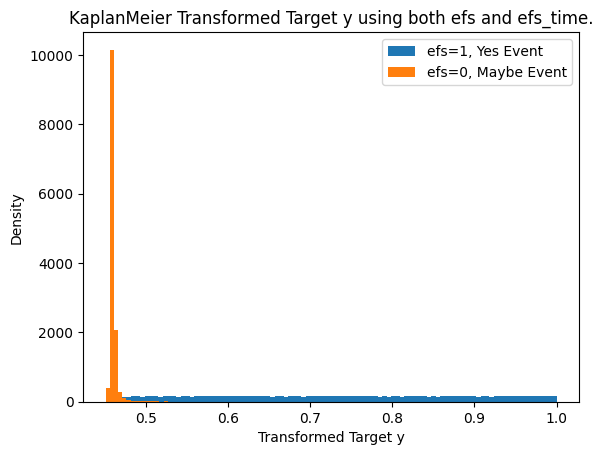

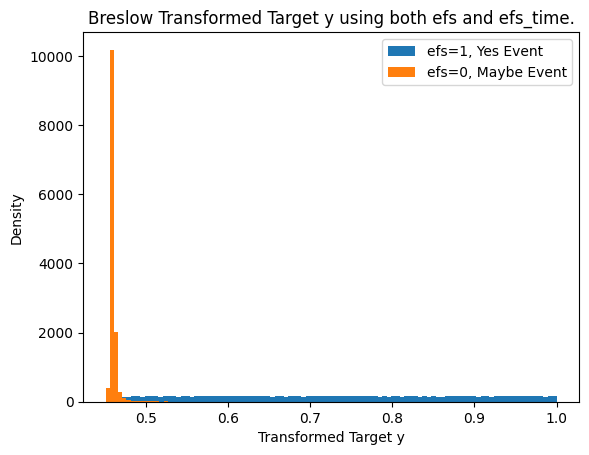

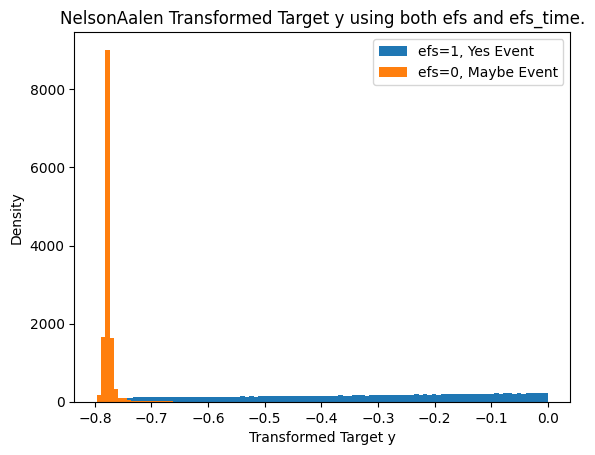

In [32]:
test = add_features(test)
train = add_features(train)
train["Kaplan"] = kaplan_transform(train)
train["Breslow"] = Breslow_transform(train)
train["nelson"] = nelson_transform(train)

In [33]:
def prepare_data_old(train, test, eps=2e-2, eps_mul=1.1, target_type='Kaplan'):
    
    RMV = ["ID", "efs", "efs_time", "y", "Breslow", "Kaplan", "nelson"]
    FEATURES = [c for c in train.columns if not c in RMV]

    CATS = []
    for c in FEATURES:
        if train[c].dtype == "object":
            CATS.append(c)
            train[c] = train[c].fillna("NAN")
            test[c] = test[c].fillna("NAN")
    print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")
    print(f"In these features, there are {len([f for f in FEATURES if f not in CATS])} NUMERICAL FEATURES: {sorted([f for f in FEATURES if f not in CATS])}")
    combined = pd.concat([train, test], axis=0, ignore_index=True)
    # print("Combined data shape:", combined.shape )
    # LABEL ENCODE CATEGORICAL FEATURES
    for c in FEATURES:

        # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
        if c in CATS:
            combined[c], _ = combined[c].factorize()
            combined[c] -= combined[c].min()
            combined[c] = combined[c].astype("int32")
            combined[c] = combined[c].astype("category")

        # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
        else:
            if combined[c].dtype == "float64":
                combined[c] = combined[c].astype("float32")
            if combined[c].dtype == "int64":
                combined[c] = combined[c].astype("int32")
    train = combined.iloc[:len(train)].copy()
    test = combined.iloc[len(train):].reset_index(drop=True).copy()
    y = train[target_type].copy()
    # y = train['Breslow'].copy()
    y = (y - y.min() + eps) / (y.max() - y.min() + eps_mul * eps)
    y = np.log(y / (1 - y))
    return FEATURES, test, train, y

In these features, there are 36 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'sex_match_bool']
In these features, there are 22 NUMERICAL FEATURES: ['age_at_hct', 'comorbidity_score', 'donor_age', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10', 'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high', 'hla_match_b_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low', 'hla_match_drb1_high', 'hla_

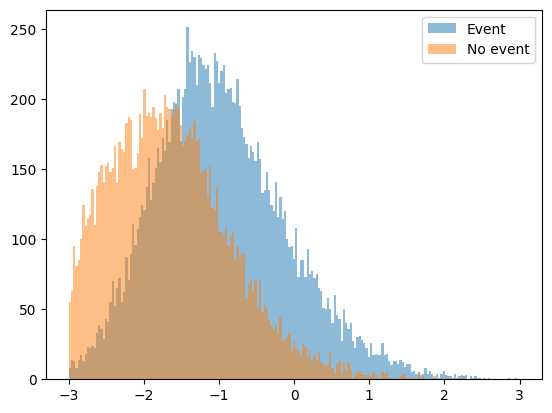


Overall CV for XGBoost KaplanMeier = 0.6804542280395464


In [34]:
CTB_MODEL_DIR = "/kaggle/input/2targets-ctb-models"
NUM_FOLDS = 10 

FEATURES, _, _, y_k = prepare_data_old(train.copy(), test.copy(), 2e-2, 1.01, target_type='Kaplan')
FEATURES, test, train, y_n = prepare_data_old(train.copy(), test.copy(), 2e-2, 1.01, target_type='nelson')
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

oof_ctb1 = np.zeros(len(train))
oof_ctb2 = np.zeros(len(train))
pred_ctb1= np.zeros(len(test))
pred_ctb2 = np.zeros(len(test))
ensemble_oof = np.zeros(len(train))

for fold_num, (train_index, test_index) in enumerate(kf.split(train, train.race_group.astype(str))):
    x_test_k, x_train_k, x_valid_k, y_train_k, y_valid_k = _prepare_training_data(
        FEATURES, test.copy(), test_index, train.copy(), train_index, y_k.copy(), pos_shift=0.2
    )
    x_test_n, x_train_n, x_valid_n, y_train_n, y_valid_n = _prepare_training_data(
        FEATURES, test.copy(), test_index, train.copy(), train_index, y_n.copy(), pos_shift=0.2
    )
    # 生成文件名
    ctb1_filename = f"ctb_kmf_fold_{fold_num}.pkl"
    ctb2_filename = f"ctb_nel_fold_{fold_num}.pkl"
    
    
    # 构建完整路径
    ctb1_path = os.path.join(CTB_MODEL_DIR, ctb1_filename)
    ctb2_path = os.path.join(CTB_MODEL_DIR, ctb2_filename)
    
    # 加载CatBoost模型
    with open(ctb1_path, "rb") as ctb1_file:
        ctb1_model = pickle.load(ctb1_file)
        print(f"✅ 成功加载 CatBoost kmf fold {fold_num}")

    with open(ctb2_path, "rb") as ctb2_file:
        ctb2_model = pickle.load(ctb2_file)
        print(f"✅ 成功加载 CatBoost nel fold {fold_num}")
        

    # INFER OOF
    oof_ctb1[test_index] = ctb1_model.predict(x_valid_k)
    oof_ctb2[test_index] = ctb2_model.predict(x_valid_n)
    ensemble_oof[test_index] = oof_ctb1[test_index] + oof_ctb2[test_index]
    # INFER TEST
    pred_ctb1 += ctb1_model.predict(x_test_k)
    pred_ctb2 += ctb2_model.predict(x_test_n)

# ensemble_pred = rankdata(pred_xgb1) + rankdata(pred_ctb1) + rankdata(pred_xgb2) + rankdata(pred_ctb2)
y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = ensemble_oof
m = score_f(y_true.copy(), y_pred.copy(), "ID")
plt.hist(ensemble_oof[train.efs==1], bins=np.linspace(-3, 3, 200), alpha=0.5, label="Event")
plt.hist(ensemble_oof[train.efs==0], bins=np.linspace(-3, 3, 200), alpha=0.5, label="No event")
plt.legend()
plt.show()
print(f"\nOverall CV for XGBoost KaplanMeier =", m)

## Model evaluation

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
import numpy as np
from scipy.stats import rankdata
from scipy.optimize import minimize

def scoring_function(z):
    y_true = train[["ID","efs","efs_time","race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = z
    m = score_f(y_true.copy(), y_pred.copy(), "ID")
    return -m

# 优化目标函数
def objective(weights):
    a, b, c, e, f, g = weights
    z = a * rankdata(oof_xgb1) + b * rankdata(oof_xgb2) + c * rankdata(oof_ctb1) + e * rankdata(pairwise_ranking_oof) + \
        f * rankdata(yun_lgb_prediction) + g * rankdata(yun_cat_prediction)
    # z = a * oof_xgb1 + b * oof_xgb2 + c * oof_ctb1 + e * pairwise_ranking_oof
    # z = a * oof_xgb1 + c * oof_ctb1 + e * pairwise_ranking_oof
    return scoring_function(z)

# 初始权重
initial_weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # a 和 b 的初始值

# 进行优化
result = minimize(objective, initial_weights, method='Nelder-Mead')

# 输出结果
best_a, best_b, best_c, best_e, best_f, best_g = result.x
best_score = -result.fun  # 由于我们最小化的是负分数，取反得到最佳分数

print(f"Best weights: a = {best_a:.8f}, b = {best_b:.8f}, c = {best_c:.8f}, e = {best_e:.8f}, f = {best_f:.8f}, g = {best_g:.8f}\n")
print(f"Best score: {best_score:.8f}")

Best weights: a = 1.74406638, b = 0.46224561, c = 0.53474268, e = 2.40429294, f = 0.42815725, g = 0.48060007

Best score: 0.68714562


In [37]:
# 学长2 target xgb + 2 target ctb -> Best score: 0.68415302 (Best weights: a = 1.58888370, b = 1.22233104, c = 0.74544615, d = 0.03345303)
# 改了params 学长2 target xgb + 2 target ctb -> Best score: 0.68422293 (Best weights: a = 1.70962972, b = 1.33834895, c = 0.53809973, d = -0.01101571)

# above are rankdata, below is mean

# 改了params 学长2 target xgb + 2 target ctb -> Best score: 0.68429274 (Best weights: a = 1.69840487, b = 1.27731312, c = 0.74772699, d = -0.16644459)
# 加入nn -> Best score: 0.68670938 (Best weights: a = 1.46798161, b = 0.35817283, c = 0.73768038, d = -0.60977607, e = 2.65685708)
    # 去掉negative weight -> Best score: 0.68664449 (Best weights: a = 1.39022456, b = 0.08631350, c = 0.24839140, e = 2.16680315)

In [38]:
from scipy.stats import rankdata
y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
y_pred = train[["ID"]].copy()
# y_pred["prediction"] = best_a * oof_xgb1 + best_b * oof_xgb2 + best_c * oof_ctb1 + best_e * pairwise_ranking_oof
y_pred["prediction"] = best_a * rankdata(oof_xgb1) + best_b * rankdata(oof_xgb2) + best_c * rankdata(oof_ctb1) + best_e * rankdata(pairwise_ranking_oof) + best_f * rankdata(yun_lgb_prediction) + best_g * rankdata(yun_cat_prediction)
m = score_f(train.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Nelson + Kaplan =", m)


Overall CV for XGBoost Nelson + Kaplan = 0.6871456230977133


In [39]:
# Overall CV for XGBoost KaplanMeier = 0.6818261746275612

# GPU + 10 folds
# Overall CV for XGBoost KaplanMeier = 0.6826966506524752
# Overall CV for XGBoost Nelson = 0.6826012942742193
# Overall CV for XGBoost Nelson + Kaplan = 0.6828632920915483

# GPU + 10 folds + tune params
# Overall CV for XGBoost KaplanMeier = 0.6831326550771525
# Overall CV for XGBoost Nelson = 0.6831810952080583
# Overall CV for XGBoost Nelson + Kaplan = 0.683452623744694

# GPU + 10 folds + tune params + added features
# 0.6834877554194293


## Create Submission CSV

In [40]:
# ensemble_pred = best_a * pred_xgb1 + best_b * pred_xgb2 + best_c * pred_ctb1 + best_e * pairwise_ranking_pred
ensemble_pred = best_a * rankdata(pred_xgb1) + best_b * rankdata(pred_xgb2) + best_c * rankdata(pred_ctb1) + best_e * rankdata(pairwise_ranking_pred) + 0.5 * rankdata(yun_preds)

In [41]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = ensemble_pred
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,11.290695
1,28801,16.936043
2,28802,5.645348
